In [357]:
import sys
import os
import time
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

print(time.strftime('%Y/%m/%d %H:%M'))
print('OS:', sys.platform)
print('CPU Cores:', os.cpu_count())
print('Python:', sys.version)
print('NumPy:', np.__version__)
print('Pandas:', pd.__version__)
print('Scikit-Learn:', sklearn.__version__)

# Displays all dataframe columns
pd.set_option('display.max_columns', None)

%matplotlib inline

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

2019/10/26 13:32
OS: win32
CPU Cores: 4
Python: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
NumPy: 1.16.4
Pandas: 0.24.2
Scikit-Learn: 0.21.2


In [2]:
df = pd.read_csv('hourly_injections.csv', header = None, names = ['date', 'hour', 'number_of_injections', 'location'])

In [3]:
#convert hour number to actual hour time
df = df.assign(hour_of_day=pd.to_datetime(df.hour, format='%H').dt.time).drop('hour', axis = 1)
df.head()

,date,number_of_injections,location,hour_of_day
0,2019-10-25,7,Jackson,07:00:00
1,2019-10-25,17,Jackson,08:00:00
2,2019-10-25,1,Diberville,08:00:00
3,2019-10-25,19,Jackson,09:00:00
4,2019-10-25,1,Diberville,09:00:00


In [6]:
#concatenate date and hours to form one datetime object
df['date'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['hour_of_day'].astype(str))

In [13]:
# df.drop('hour_of_day', axis = 1, inplace = True)

## Partitioning data into clinic location dataframes

In [148]:
jackson = df.sort_values('date')[df['location'] == 'Jackson']
jackson.head()

C:\Users\Sam Cannon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,date,number_of_injections,location
32358,2016-01-04 07:00:00,11,Jackson
32362,2016-01-04 08:00:00,19,Jackson
32366,2016-01-04 09:00:00,17,Jackson
32370,2016-01-04 10:00:00,25,Jackson
32374,2016-01-04 11:00:00,14,Jackson


In [20]:
diberville = df.sort_values('date')[df['location'] == 'Diberville']
diberville.head()

C:\Users\Sam Cannon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,date,number_of_injections,location
32054,2016-01-19 09:00:00,2,Diberville
28110,2016-08-11 14:00:00,5,Diberville
28114,2016-08-11 15:00:00,2,Diberville
27791,2016-08-29 11:00:00,1,Diberville
27705,2016-09-01 14:00:00,1,Diberville


In [21]:
oxford = df.sort_values('date')[df['location'] == 'Oxford']
oxford.head()

C:\Users\Sam Cannon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,date,number_of_injections,location
32357,2016-01-04 07:00:00,1,Oxford
32361,2016-01-04 08:00:00,4,Oxford
32365,2016-01-04 09:00:00,3,Oxford
32369,2016-01-04 10:00:00,7,Oxford
32373,2016-01-04 11:00:00,7,Oxford


In [22]:
ridgeland = df.sort_values('date')[df['location'] == 'Ridgeland']
ridgeland.head()

C:\Users\Sam Cannon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,date,number_of_injections,location
32356,2016-01-04 07:00:00,5,Ridgeland
32360,2016-01-04 08:00:00,5,Ridgeland
32364,2016-01-04 09:00:00,7,Ridgeland
32368,2016-01-04 10:00:00,11,Ridgeland
32372,2016-01-04 11:00:00,6,Ridgeland


In [24]:
meridian = df.sort_values('date')[df['location'] == 'Meridian']
meridian.tail()

C:\Users\Sam Cannon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,date,number_of_injections,location
38,2019-10-24 12:00:00,1,Meridian
42,2019-10-24 13:00:00,8,Meridian
47,2019-10-24 14:00:00,5,Meridian
52,2019-10-24 15:00:00,12,Meridian
57,2019-10-24 16:00:00,7,Meridian


## Begin Forecasting

In [149]:
#have to make the dataframe into ds and y columns 
jackson.rename(columns = {'date':'ds', 'number_of_injections':'y'}, inplace = True)
jackson.head()

,ds,y,location
32358,2016-01-04 07:00:00,11,Jackson
32362,2016-01-04 08:00:00,19,Jackson
32366,2016-01-04 09:00:00,17,Jackson
32370,2016-01-04 10:00:00,25,Jackson
32374,2016-01-04 11:00:00,14,Jackson


In [150]:
#now I need to drop the location column
jackson.drop('location', axis = 1, inplace = True)
jackson.head()

,ds,y
32358,2016-01-04 07:00:00,11
32362,2016-01-04 08:00:00,19
32366,2016-01-04 09:00:00,17
32370,2016-01-04 10:00:00,25
32374,2016-01-04 11:00:00,14


## Forecast and Create Future Dataframe
- I do want to note here that after I removed the weekends from the forecast, the predictions got significantly better

C:\Users\Sam Cannon\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



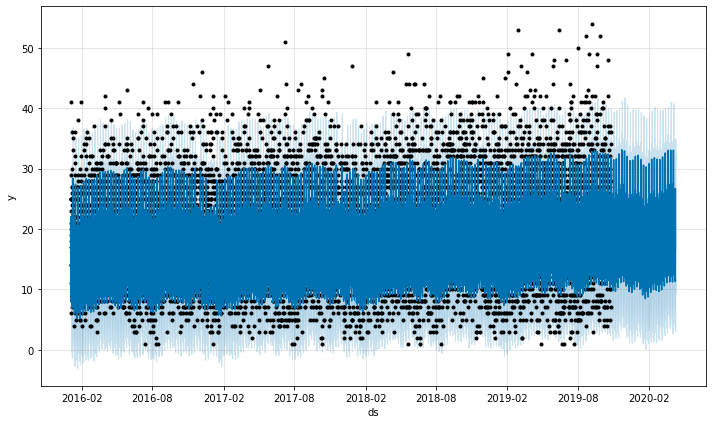

In [200]:
m = Prophet(changepoint_prior_scale=0.01).fit(jackson)

#creating future dataframe to predict with
future = m.make_future_dataframe(periods=4000, freq='H')

#cutting out weekends from data, since we dont have data for weekends
future = future[future['ds'].dt.dayofweek < 5]

#cutting out hours that aren't business hours
future = future[(future['ds'].dt.hour >= 7) & (future['ds'].dt.hour <= 16)]


fcst = m.predict(future)
fig = m.plot(fcst)

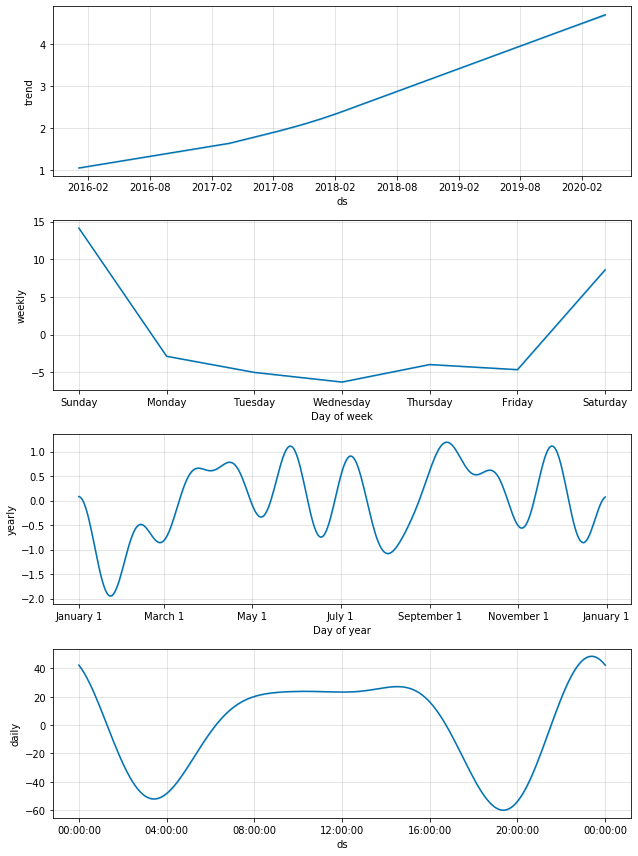

In [201]:
fig = m.plot_components(fcst)

## Looking at predictions and 95% CIs

In [202]:
fcst.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
10779,2020-04-08 12:00:00,4.709393,15.386343,31.366886,4.694062,4.726416,18.496281,18.496281,18.496281,23.282133,23.282133,23.282133,-5.476579,-5.476579,-5.476579,0.690727,0.690727,0.690727,0.0,0.0,0.0,23.205674
10780,2020-04-08 13:00:00,4.709517,16.106875,31.508484,4.694184,4.726549,19.503759,19.503759,19.503759,24.149332,24.149332,24.149332,-5.337149,-5.337149,-5.337149,0.691576,0.691576,0.691576,0.0,0.0,0.0,24.213276
10781,2020-04-08 14:00:00,4.709641,19.072697,34.481149,4.694305,4.726683,21.984460,21.984460,21.984460,26.485488,26.485488,26.485488,-5.193455,-5.193455,-5.193455,0.692427,0.692427,0.692427,0.0,0.0,0.0,26.694101
10782,2020-04-08 15:00:00,4.709765,18.190639,34.964818,4.694427,4.726817,21.913304,21.913304,21.913304,26.267521,26.267521,26.267521,-5.047496,-5.047496,-5.047496,0.693280,0.693280,0.693280,0.0,0.0,0.0,26.623069
10783,2020-04-08 16:00:00,4.709889,9.160652,24.775747,4.694548,4.726951,12.076953,12.076953,12.076953,16.284148,16.284148,16.284148,-4.901328,-4.901328,-4.901328,0.694133,0.694133,0.694133,0.0,0.0,0.0,16.786842


## Looks like our model is not doing awesome capturing the hourly data, probably due to high variance and a lack of pattern
__This leads me to believe that maybe I should be aggregating this data daily and making forecasts that way__

(737340, 737350)

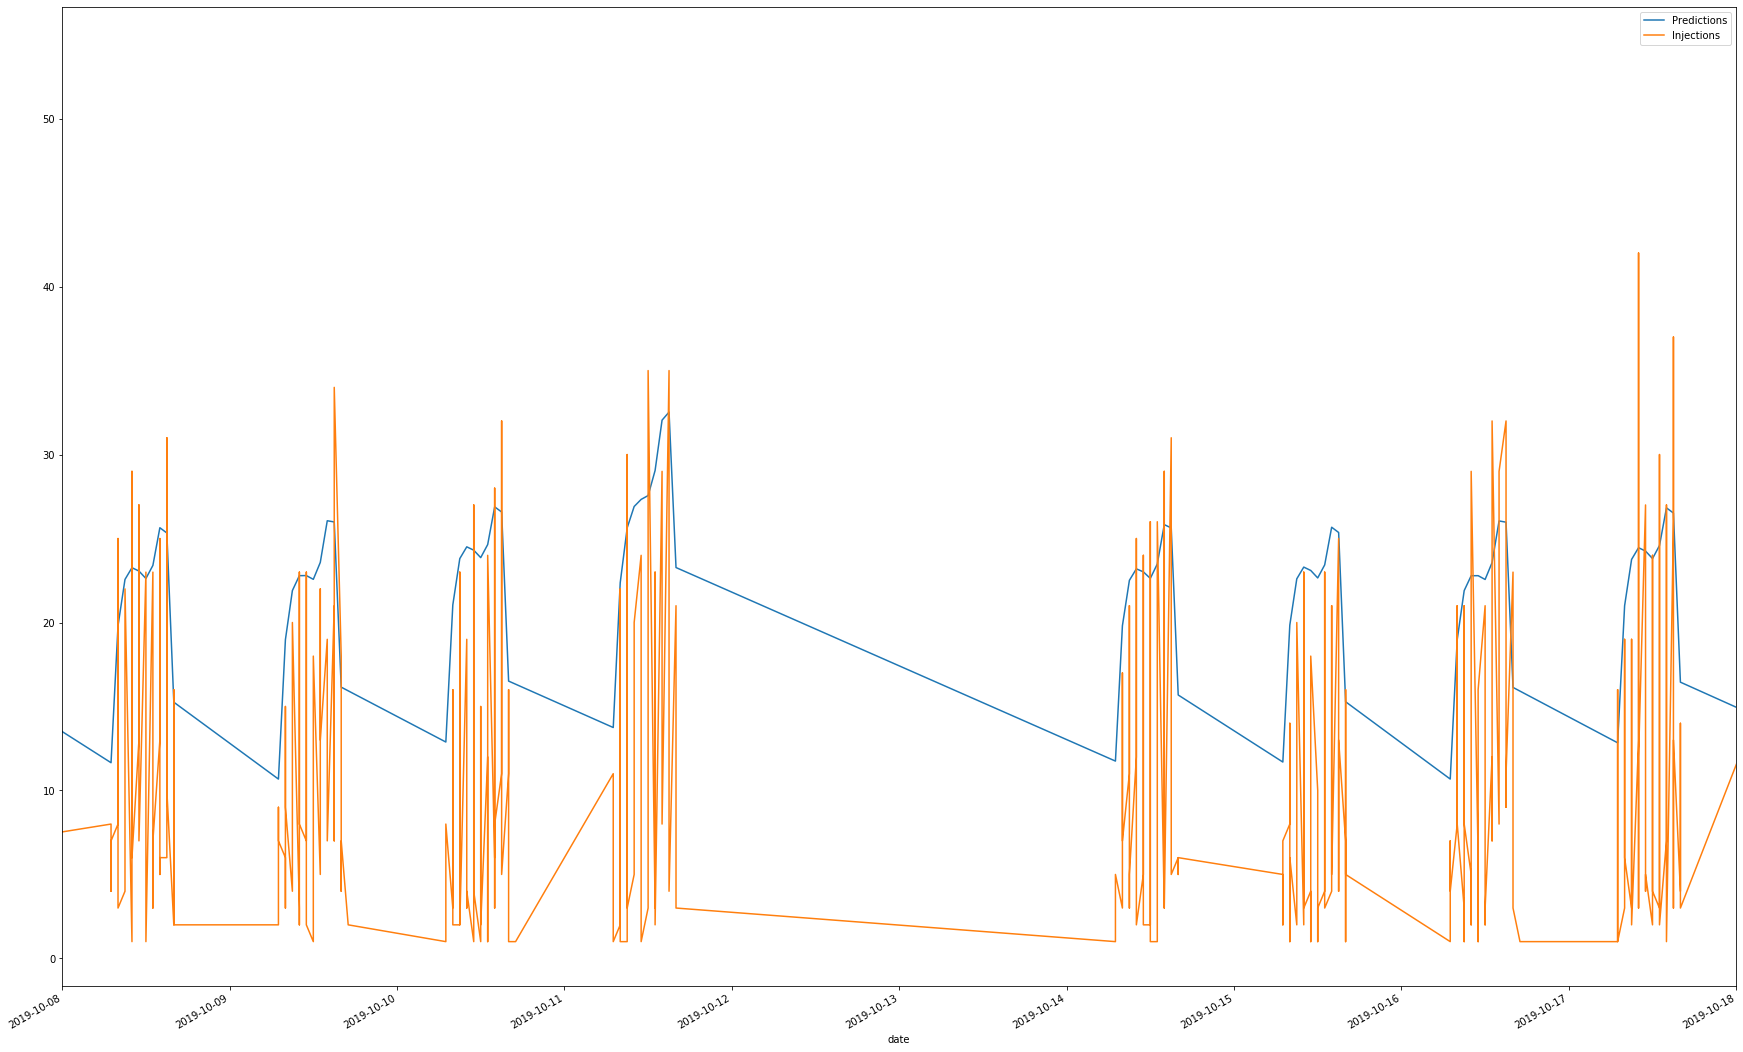

In [249]:
ax = fcst.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(30,20))

df.plot(x='date',y='number_of_injections',label='Injections',legend=True,ax=ax)

plt.xlim(737340, 737350)

## Predictions
__- Looks like we can predict hourly injections +- 8 - 10, wish there was more pattern in the data__

__- One thing is clear though, there are always less injections at 7:00 AM and 4:00 PM every day__

In [369]:
fcst[fcst['ds'] >= '2019-10-24'].head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
9584,2019-10-24 07:00:00,4.211786,3.724327,19.924087,4.211786,4.211786,8.181052,8.181052,8.181052,11.963578,11.963578,11.963578,-3.856866,-3.856866,-3.856866,0.074341,0.074341,0.074341,0.0,0.0,0.0,12.392839
9585,2019-10-24 08:00:00,4.211910,11.908910,28.564028,4.211910,4.211910,16.338859,16.338859,16.338859,20.171980,20.171980,20.171980,-3.903844,-3.903844,-3.903844,0.070722,0.070722,0.070722,0.0,0.0,0.0,20.550769
9586,2019-10-24 09:00:00,4.212034,15.236607,31.597718,4.212034,4.212034,19.093632,19.093632,19.093632,22.990026,22.990026,22.990026,-3.963494,-3.963494,-3.963494,0.067100,0.067100,0.067100,0.0,0.0,0.0,23.305666
9587,2019-10-24 10:00:00,4.212158,15.979644,32.140428,4.212158,4.212158,19.789596,19.789596,19.789596,23.760200,23.760200,23.760200,-4.034078,-4.034078,-4.034078,0.063474,0.063474,0.063474,0.0,0.0,0.0,24.001754
9588,2019-10-24 11:00:00,4.212282,15.218978,32.662129,4.212282,4.212282,19.586370,19.586370,19.586370,23.640086,23.640086,23.640086,-4.113559,-4.113559,-4.113559,0.059844,0.059844,0.059844,0.0,0.0,0.0,23.798653


# Daily Forecasting 
- Now lets see how the forecast behaves once we roll up into daily injections

In [335]:
df2 = pd.read_csv('daily_injections.csv', header = None, names = ['date', 'day', 'number_of_injections', 'location'])
df2.head()

,date,day,number_of_injections,location
0,2019-10-25,25,211,Jackson
1,2019-10-24,24,217,Jackson
2,2019-10-23,23,224,Jackson
3,2019-10-22,22,215,Jackson
4,2019-10-21,21,238,Jackson


In [336]:
df2.sort_values('date', inplace = True)
df2.head()

,date,day,number_of_injections,location
965,2016-01-04,4,217,Jackson
964,2016-01-05,5,196,Jackson
963,2016-01-06,6,175,Jackson
962,2016-01-07,7,176,Jackson
961,2016-01-08,8,216,Jackson


In [337]:
# I think we can delete dat since it is redundany
df2.drop('day', axis = 1, inplace = True)

#rename columns for prophet
df2.rename(columns = {'date':'ds', 'number_of_injections':'y'}, inplace = True)
df2.head()

,ds,y,location
965,2016-01-04,217,Jackson
964,2016-01-05,196,Jackson
963,2016-01-06,175,Jackson
962,2016-01-07,176,Jackson
961,2016-01-08,216,Jackson


In [338]:
# #drop location
df2.drop('location', axis = 1, inplace = True)
df2['ds'] = pd.to_datetime(df2.ds)

In [268]:
#instantiate a prophet model and fit it to the data
magic = Prophet()
magic.fit(df2)

#create future df for predictions
future2 = magic.make_future_dataframe(periods=365, freq = 'D')
#make sure we are cutting out weekends
future2 = future2[future2['ds'].dt.dayofweek < 5]

#forecast the data
forecast2 = magic.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Sam Cannon\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



,ds,yhat,yhat_lower,yhat_upper
1221,2020-10-19,223.220611,190.004338,255.723805
1222,2020-10-20,223.566379,187.179178,257.716309
1223,2020-10-21,223.974241,190.988384,259.083887
1224,2020-10-22,232.295722,199.568438,265.664936
1225,2020-10-23,266.868668,234.712182,298.342746


## Should consider removing the outliers

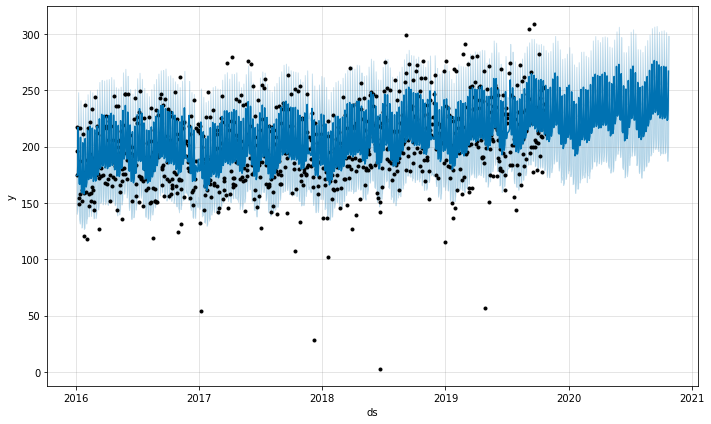

In [269]:
forecast_plot = magic.plot(forecast2)

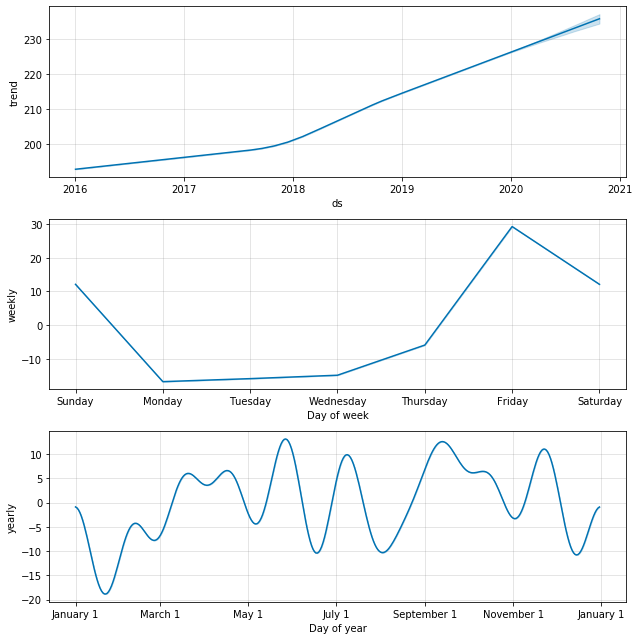

In [271]:
components = magic.plot_components(forecast2)

## Dealing with outliers

In [339]:
df2.head()

,ds,y
965,2016-01-04,217
964,2016-01-05,196
963,2016-01-06,175
962,2016-01-07,176
961,2016-01-08,216


In [340]:
df2.reset_index(inplace = True, drop = True)

__Looking at the plot above, it appears that we have 4 clear outliers that are all less than 60, now whether or not these are accurate is questionable, so I am going to set their values to NA and allow the model to predict them in the future__

In [344]:
outliers = df2[df2['y'] < 60]
outliers.head()

,ds,y
256,2017-01-06,54
491,2017-12-08,28
625,2018-06-21,3
840,2019-04-29,57


In [345]:
#replace outliers with NA
outliers = []
for x in df2['y']:
    if x < 60:
        outliers.append(np.nan)
    else:
        outliers.append(x)
df2['y'] = outliers

In [346]:
#now lets see if the outliers are present still
df2[df2['y'] < 60]

,ds,y


In [348]:
#double check 
df2.iloc[[256, 257, 491, 625, 840], :]

,ds,y
256,2017-01-06,NaN
257,2017-01-09,181.0
491,2017-12-08,NaN
625,2018-06-21,NaN
840,2019-04-29,NaN


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Sam Cannon\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



,ds,yhat,yhat_lower,yhat_upper
1221,2020-10-19,221.248725,192.637455,250.049774
1222,2020-10-20,220.887823,192.932220,248.610350
1223,2020-10-21,221.254927,191.665091,248.345119
1224,2020-10-22,230.591776,202.865957,258.984438
1225,2020-10-23,266.089992,239.238129,293.941573


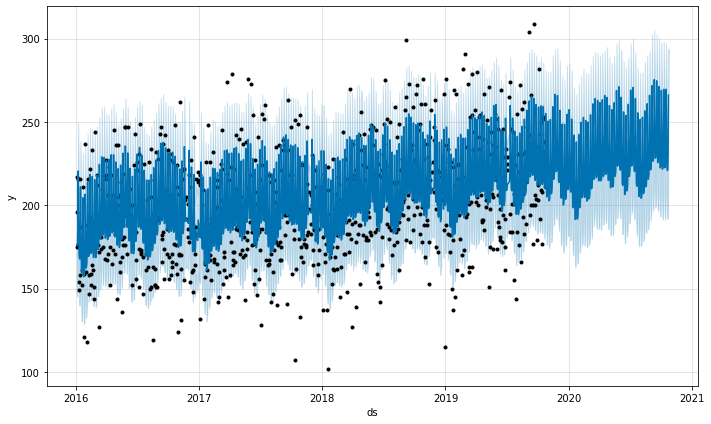

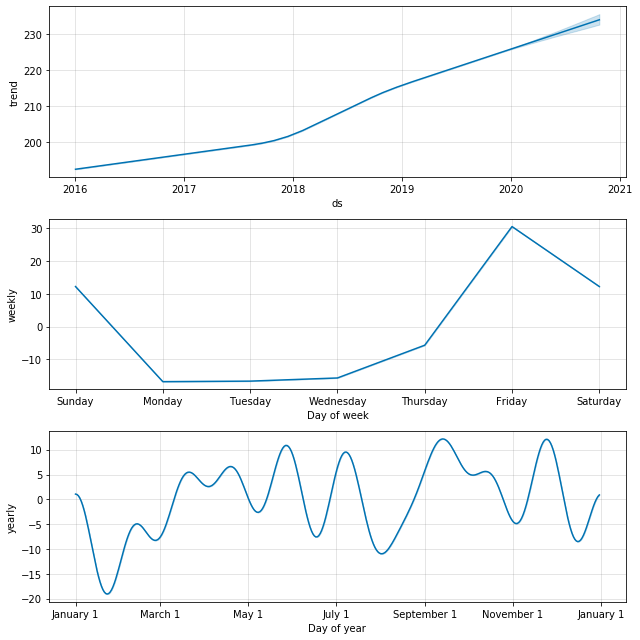

In [355]:
#now forecast again
#instantiate a prophet model and fit it to the data
magic2 = Prophet()
magic2.fit(df2)

#create future df for predictions
future3 = magic2.make_future_dataframe(periods=365, freq = 'D')
#make sure we are cutting out weekends
future3 = future3[future3['ds'].dt.dayofweek < 5]

#forecast the data
forecast3 = magic2.predict(future3)
forecast3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plot the forecast
forecast_plot3 = magic2.plot(forecast3)

#plot the seasonality
components3 = magic2.plot_components(forecast3)

## Cross Validate the model
- here we are going to use 900 days of the training data to predict every 10 days in a 200 day period

In [358]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(magic2, initial='900 days', period='10 days', horizon = '200 days')
df_cv.head()

INFO:fbprophet:Making 30 forecasts with cutoffs between 2018-06-22 00:00:00 and 2019-04-08 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-06-25,175.407532,147.655796,203.856729,217.0,2018-06-22
1,2018-06-26,179.831021,152.531841,207.631799,221.0,2018-06-22
2,2018-06-27,182.706325,155.324731,210.174985,181.0,2018-06-22
3,2018-06-28,193.710168,166.158804,221.231080,164.0,2018-06-22
4,2018-06-29,227.605253,198.570073,255.951125,231.0,2018-06-22


In [359]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,20 days,614.898936,24.797156,19.349756,0.093591,0.739482
1,21 days,617.664980,24.852867,19.410088,0.094002,0.742233
2,22 days,620.091046,24.901627,19.390199,0.093964,0.742207
3,23 days,615.216510,24.803558,19.286200,0.093558,0.744337
4,24 days,613.095141,24.760758,19.255963,0.093523,0.750971


## So...our RMSE is around 24, so I can predict daily injections +- 24, I wonder if this is useful

In [360]:
df_p.head(30)

,horizon,mse,rmse,mae,mape,coverage
0,20 days,614.898936,24.797156,19.349756,0.093591,0.739482
1,21 days,617.664980,24.852867,19.410088,0.094002,0.742233
2,22 days,620.091046,24.901627,19.390199,0.093964,0.742207
3,23 days,615.216510,24.803558,19.286200,0.093558,0.744337
4,24 days,613.095141,24.760758,19.255963,0.093523,0.750971
5,25 days,613.083520,24.760523,19.255594,0.093512,0.751456
6,26 days,613.969165,24.778401,19.216528,0.093214,0.750993
7,27 days,615.349999,24.806249,19.221774,0.093272,0.752080
8,28 days,610.561492,24.709543,19.109039,0.092790,0.753814
9,29 days,614.834460,24.795856,19.222609,0.093253,0.753089


# Tune Hyperparameters with Prophet
- Here we are going to use logistic growth since there is a saturation point with injections
- We are also going to model for multiplicative seasonality since the trend is growing with the seasonality
- We are going to specify a cap for the data, since theres no way that injections can grow exponentially, I set the cap at 300 since that is about as high as the residuals go
 - We must set a cap for the original dataframe and the future dataframe
- Helpful resource: https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1481,2021-10-18,232.202176,204.632897,261.580026
1482,2021-10-19,231.556896,203.996936,259.088731
1483,2021-10-20,232.093556,201.971716,259.152659
1484,2021-10-21,243.211138,213.865978,268.775192
1485,2021-10-22,286.064583,254.852743,314.408951


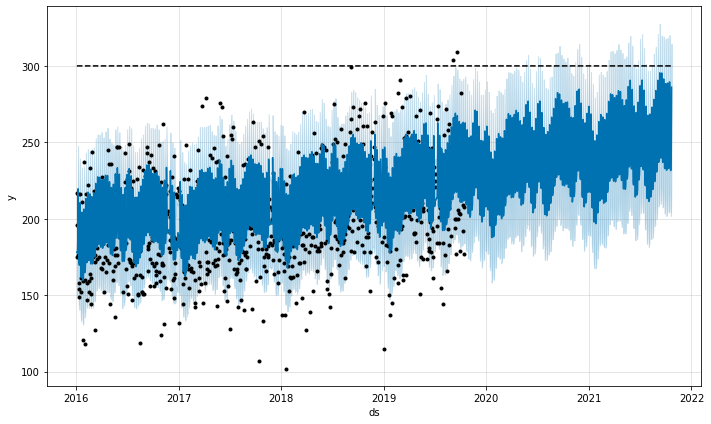

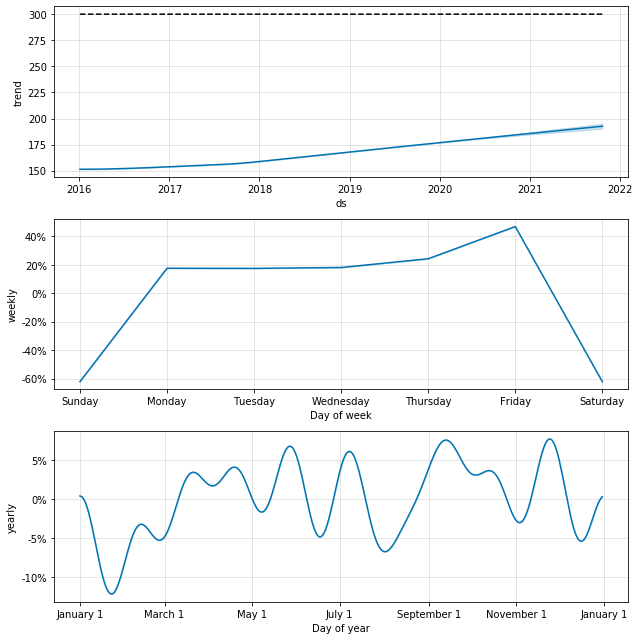

In [361]:
#now forecast again
#instantiate a prophet model and fit it to the data

#tune growth = 'logistic' since the trend should saturate at a point
#also look at multiplicative seasonality since the injection trends are growing every year
magic3 = Prophet(growth = 'logistic', seasonality_mode = 'multiplicative')

#create a column in df2 with the 'cap' specified - I am using 300 as this seems to be the limit of injections potentially
df2['cap'] = 300
magic3.fit(df2)

#create future df for predictions - predicting 2 years into the future
future4 = magic3.make_future_dataframe(periods=730, freq = 'D')
#make sure we are cutting out weekends
future4 = future4[future4['ds'].dt.dayofweek < 5]
future4['cap'] = 300

#forecast the data
forecast4 = magic3.predict(future4)
forecast4[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plot the forecast
forecast_plot4 = magic3.plot(forecast4)

#plot the seasonality
components4 = magic3.plot_components(forecast4)

In [365]:
forecast4[(forecast4['ds'] > '2019-10-20') & (forecast4['ds'] < '2019-10-26')]

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
961,2019-10-21,175.102264,300,179.802499,239.239329,175.102264,175.102264,0.198517,0.198517,0.198517,0.175817,0.175817,0.175817,0.022700,0.022700,0.022700,0.0,0.0,0.0,209.863093
962,2019-10-22,175.126710,300,180.666527,238.276896,175.126710,175.126710,0.193748,0.193748,0.193748,0.175112,0.175112,0.175112,0.018635,0.018635,0.018635,0.0,0.0,0.0,209.057127
963,2019-10-23,175.151156,300,178.601507,238.452639,175.151156,175.151156,0.195255,0.195255,0.195255,0.181089,0.181089,0.181089,0.014166,0.014166,0.014166,0.0,0.0,0.0,209.350239
964,2019-10-24,175.175599,300,191.284056,248.151426,175.175599,175.175599,0.251901,0.251901,0.251901,0.242524,0.242524,0.242524,0.009377,0.009377,0.009377,0.0,0.0,0.0,219.302472
965,2019-10-25,175.200042,300,230.591698,288.255684,175.200042,175.200042,0.473575,0.473575,0.473575,0.469205,0.469205,0.469205,0.004370,0.004370,0.004370,0.0,0.0,0.0,258.170456


In [364]:
df2[(df2['ds'] > '2019-10-20') & (df2['ds'] < '2019-10-26')]

,ds,y,cap
961,2019-10-21,238.0,300
962,2019-10-22,215.0,300
963,2019-10-23,224.0,300
964,2019-10-24,217.0,300
965,2019-10-25,211.0,300


## Final Cross-Validation
- Looks like our RMSE improved ever-so-slightly

In [366]:
#cross validate with the same time frame as before
df_cv2 = cross_validation(magic3, initial='1000 days', period='30 days', horizon = '180 days')

#grab our RMSE and MAPE
df_p2 = performance_metrics(df_cv2)
df_p2.head()

INFO:fbprophet:Making 8 forecasts with cutoffs between 2018-09-30 00:00:00 and 2019-04-28 00:00:00


,horizon,mse,rmse,mae,mape,coverage
0,18 days,621.007528,24.920023,18.726598,0.091053,0.753535
1,19 days,551.470016,23.483399,17.731898,0.083961,0.777778
2,20 days,523.838491,22.887518,17.389084,0.081803,0.783838
3,21 days,598.212354,24.458380,18.318041,0.086892,0.767677
4,22 days,619.973546,24.899268,18.782862,0.089709,0.747475
